# Example
A high dimensional data set has monte carlo integration applied.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import OneClassSVM

from highd import HighD

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [3]:
iris = load_breast_cancer()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df["species"].value_counts())
print("Shape:", df.shape)
df.head()

benign       357
malignant    212
Name: species, dtype: int64
Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,species
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


Drop species as it is the target.

In [4]:
targets = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [5]:
hd = HighD(df, targets)

In [6]:
# hd.scatter_plot_matrix()

In [7]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    hd.scaled, hd.targets, test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print("F1 score:", f1_score(y_test, preds, pos_label="malignant"))
print("Confusion matrix:")
print(confusion_matrix(y_test, preds))

F1 score: 0.9465648854961832
Confusion matrix:
[[119   2]
 [  5  62]]


## Classifier Training and Analysis

### Random Forests

In [8]:
def clf_func(df):
    proba = clf.predict_proba(df)
    return np.array([i[1] for i in proba])

In [9]:
hd.density_estimate(clf_func, n=10000)

/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


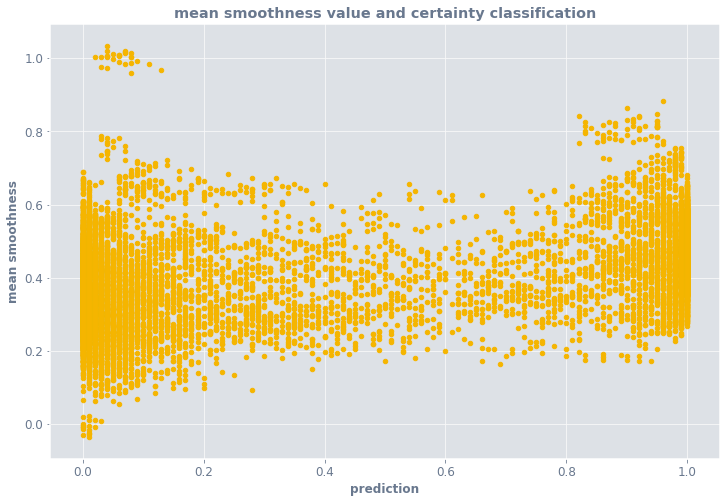

In [10]:
hd.density_scatter("mean smoothness")

Select 5 most important features to visualize.

In [11]:
features = [(f, i) for f, i in zip(hd.scaled.columns, clf.feature_importances_)]   
# features.sort(key=lambda x: x[1], reverse=True)
features = [i[0] for i in features[:5]]
print(features)

hd.select_vis_cols(features, n_bins=25)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


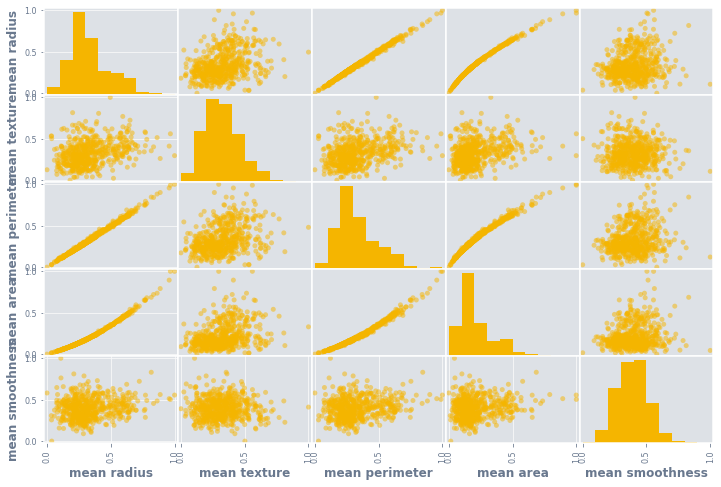

In [12]:
hd.scatter_plot_matrix(features)

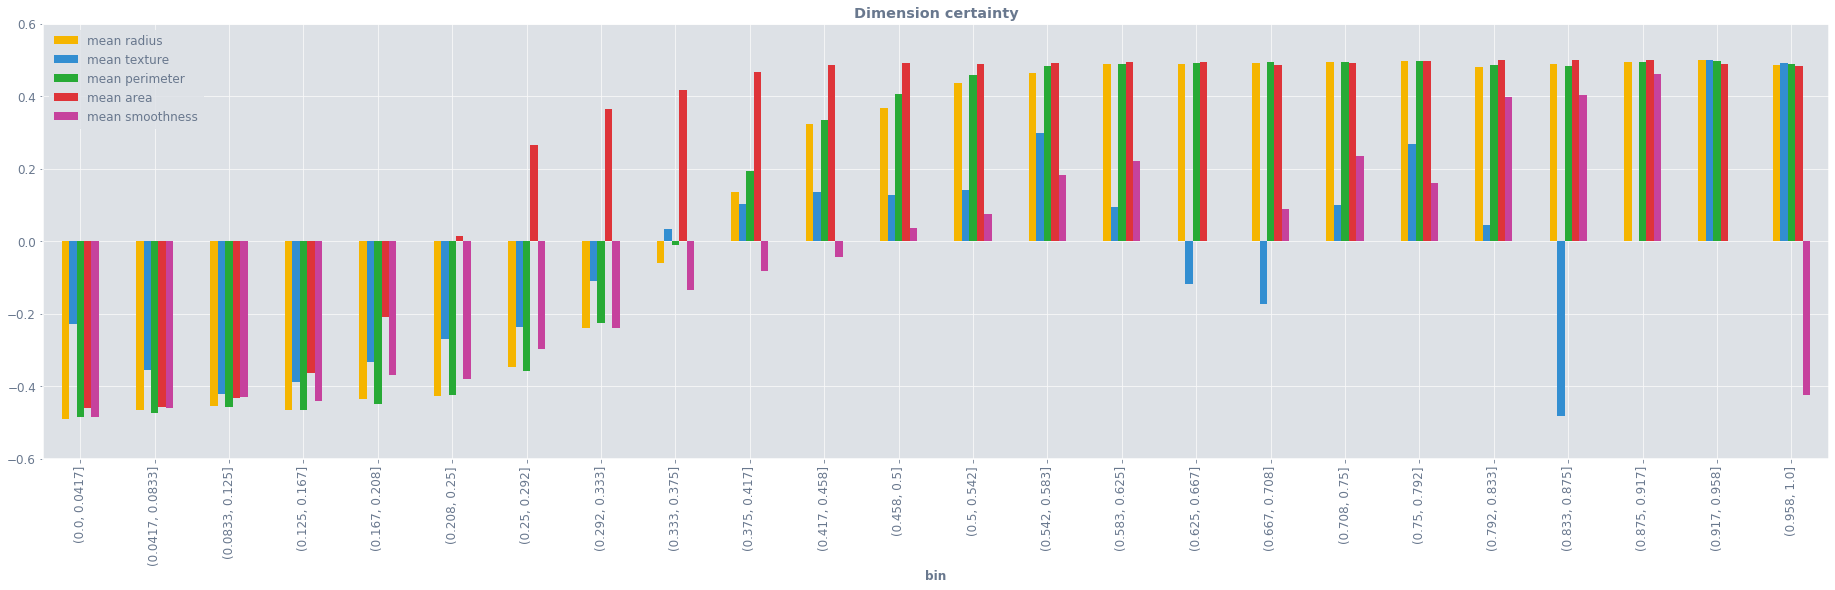

In [13]:
hd.vis_1d(figsize=(32, 8))

Everything red will be classified as malignant, everything blue will be classified as benign.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


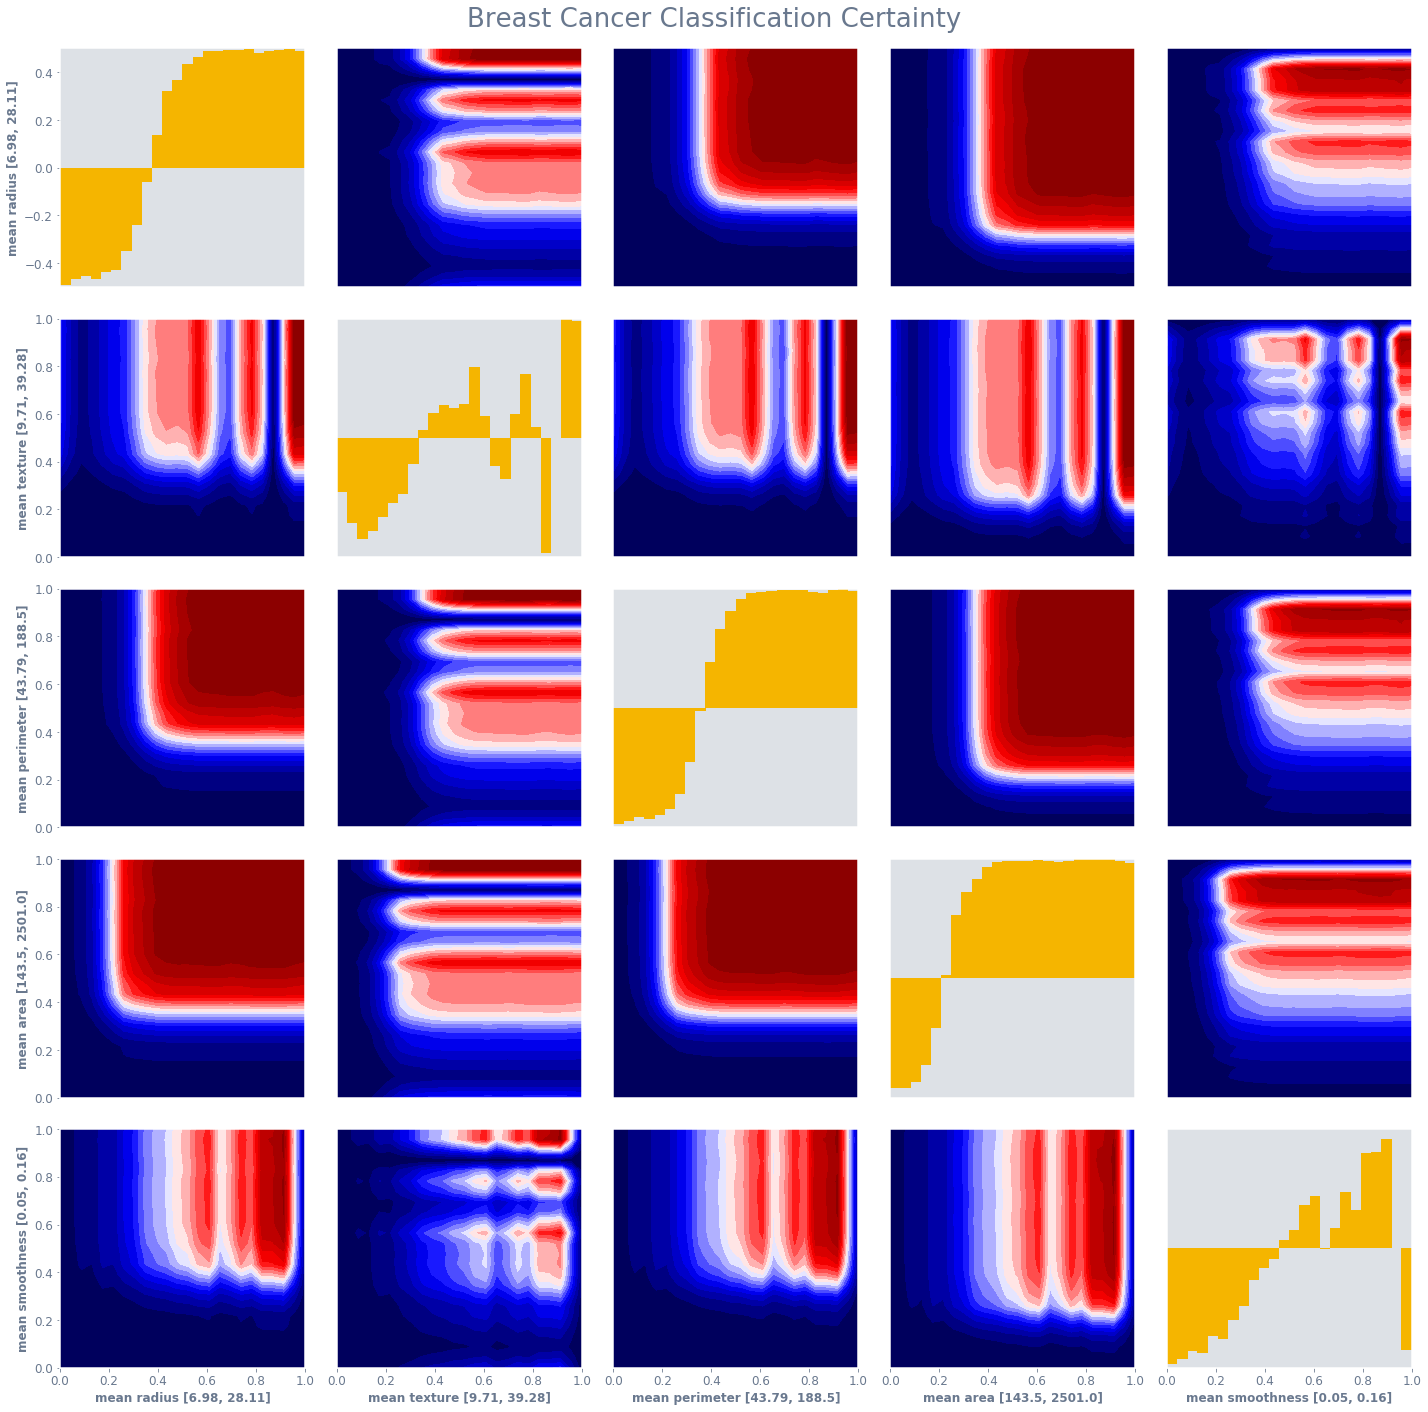

In [14]:
hd.vis_2d(title="Breast Cancer Classification Certainty")

### One Class SVM
Used for outlier detection/estimating a learning frontier. The SVM is set to use 10% of points estimated as outliers to set the learning frontier.

In [15]:
clf = OneClassSVM(gamma='auto', nu=0.1).fit(hd.scaled)

In [16]:
# Certainty 
def clf_func(df):
    pred = clf.predict(df)
#     max_val = max(pred)
#     pred = [i / (max_val) + 1.0 for i in pred]
#     print()
#     return np.array([i[1] for i in proba])
    return [(i + 1) / 2 for i in pred]

In [17]:
tst = clf_func(hd.scaled)
pd.Series(tst).value_counts()

1.0    512
0.0     57
dtype: int64

In [18]:
hd.density_estimate(clf_func, n=10000)

/Users/eraymond/Documents/github/highd-vis/highd/__init__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["bin"] = pd.cut(tmp[col], bins=res_vals)


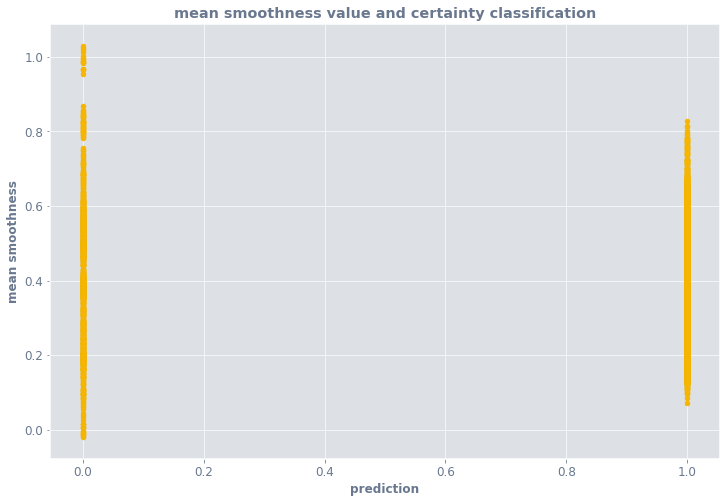

In [19]:
hd.density_scatter("mean smoothness")

In [20]:
hd.select_vis_cols(features, n_bins=25)

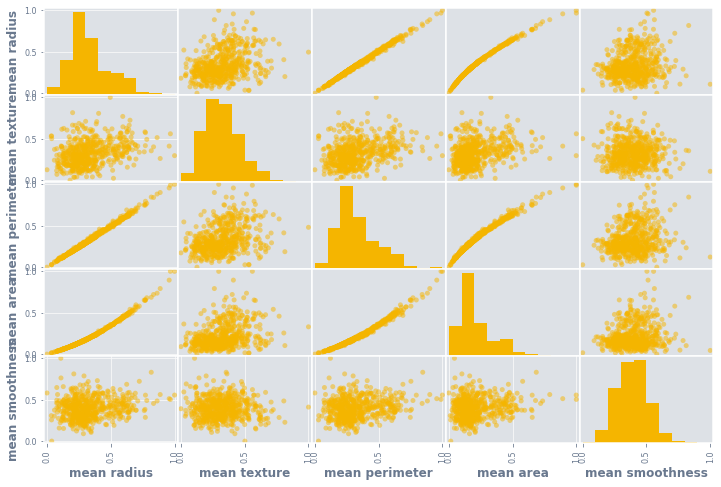

In [21]:
hd.scatter_plot_matrix(features)

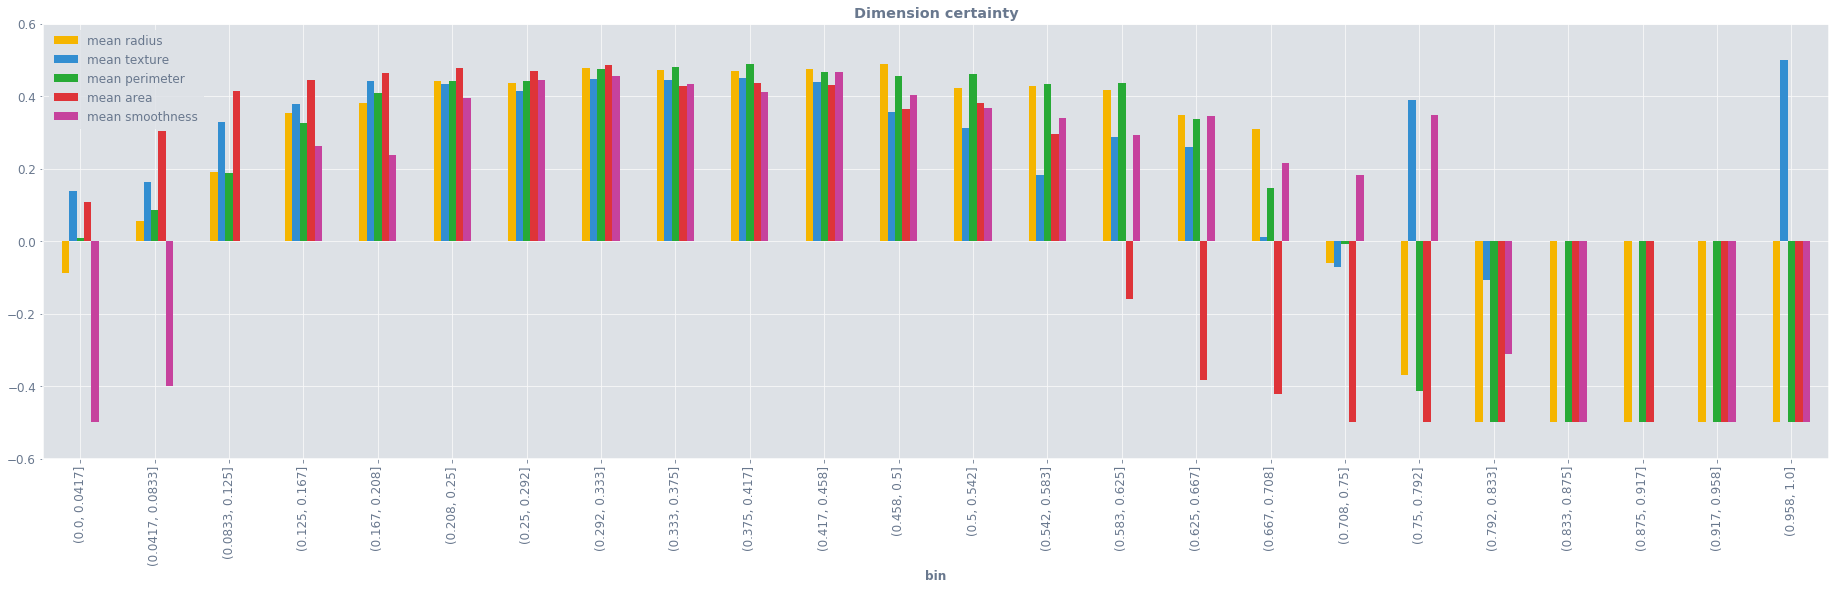

In [22]:
hd.vis_1d(figsize=(32, 8))

Red will be classified as within range of the classifier, while blue will be classified as outliers.

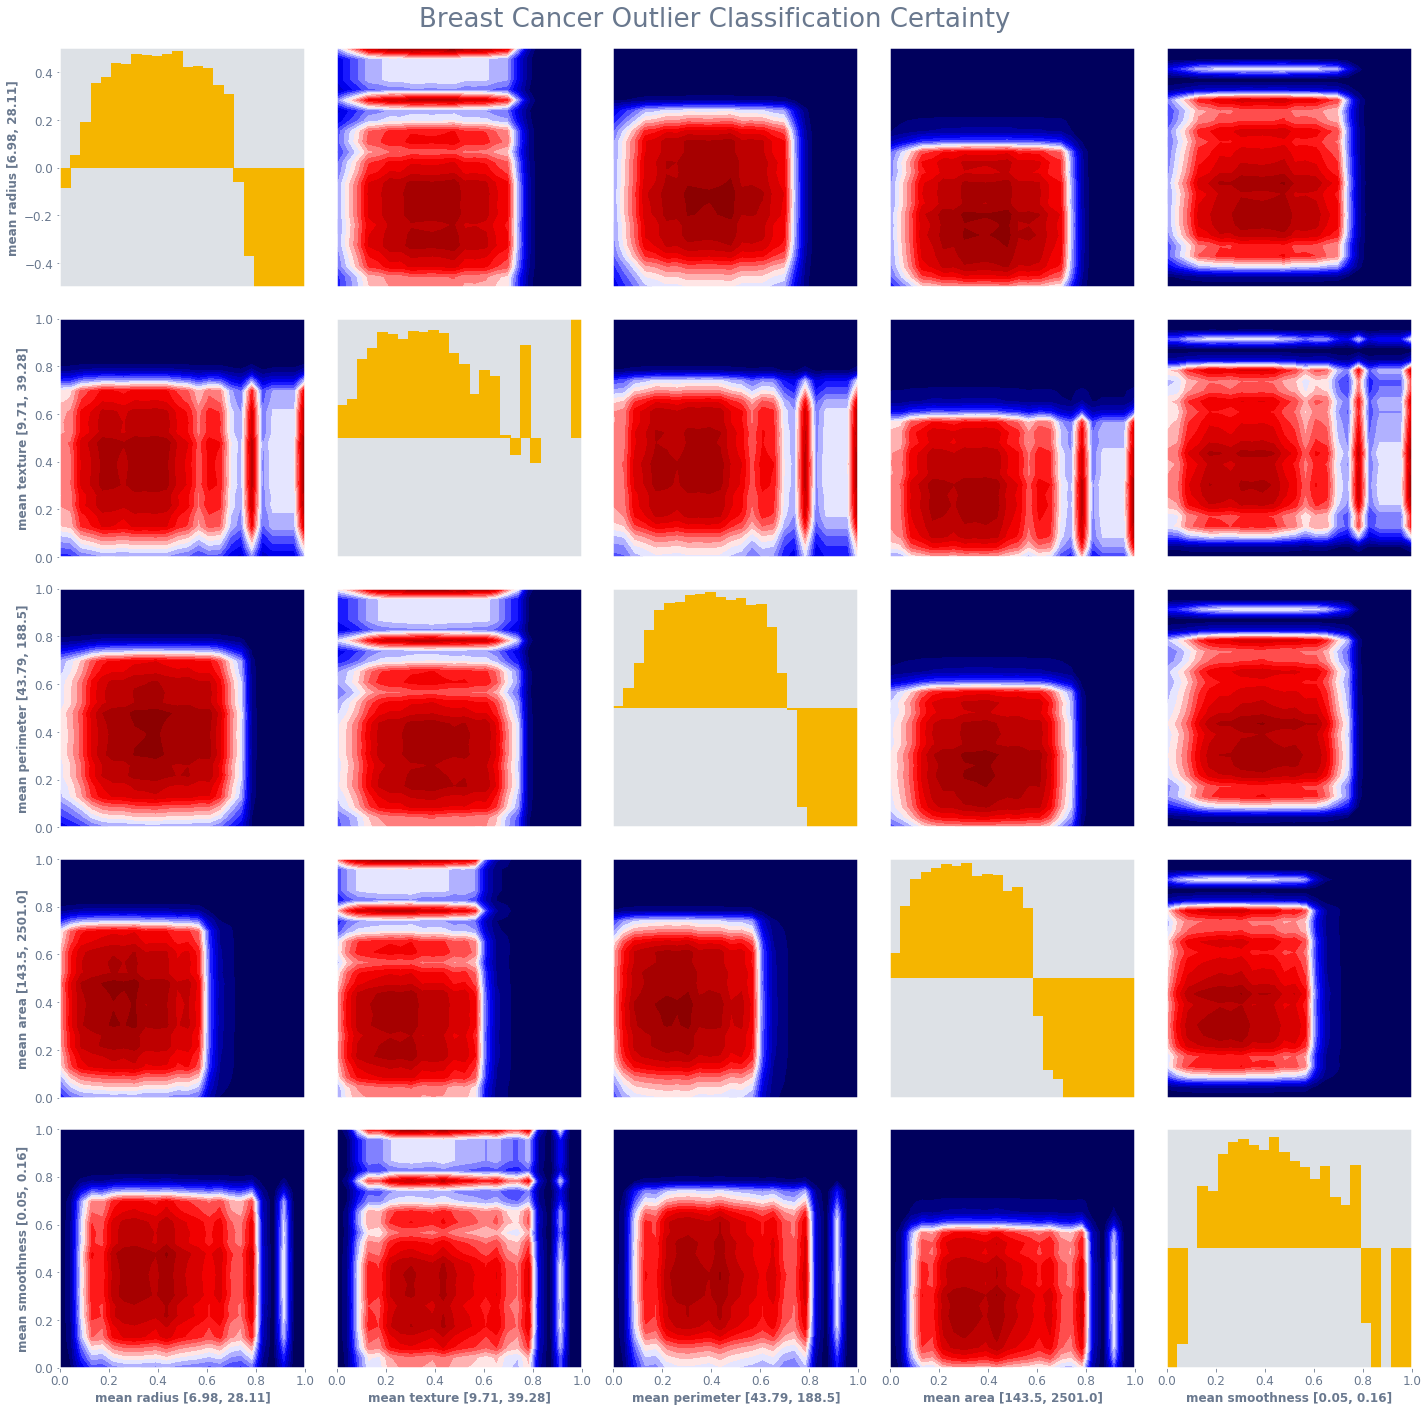

In [25]:
hd.vis_2d(title="Breast Cancer Outlier Classification Certainty")

## Classifier and Outlier Detection Superposition